In [1]:
import os
import torch
from torch import nn
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# Set fixed random number seed
torch.manual_seed(42)

# Dataset Manipulation

The first thing we need to do is <font color=DeepPink>**load the dataset**</font>. 

This will automatically download the training set for the **CIFAR10** dataset and save it in a folder called `data`. It will create the folder if it does not exist.

We transform them to Tensors of normalized range [-1, 1].

In [3]:
# Hyperparameters
dataroot = 'data'
batch_size = 1024

# load dataset
transform = transforms.Compose([transforms.ToTensor()])

train_data = CIFAR10(dataroot, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)

test_data = CIFAR10(dataroot, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


# Neural Network

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. 

Specifically, first we will flatten our 3x32x32 (3 color channel, 32 pixels height and width) image into a 3072 element vector, also called 3072 features. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 3072 dimensional input is passed through the first hidden layer to transform it into 1024 dimensions. Then, another hidden layer, which will transform it to 512 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten categories, so need our output to be 10 dimensions.

```torch.nn.Linear()``` applies a linear transformation to the incoming data: $ y = xW^T+b $

Example: the input tensor ```x.shape=[10, 3072]```, where 10 is the batch size. We set two parameters of ```torch.nn.Linear()``` are 3072 and 1024, which means that ```W.shape=[1024, 3072]```, so the shape of $ W^T $ is ```W^T.shape=[3072, 1024]``` and the shape of $ b $ is ```b.shape=[1024]```. Using the formula, we can get $ y $ with the shape ```y.shape=[10, 1024]```.

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, activation, dim, n_layer):
        super().__init__()
        model = [nn.Flatten(),
                nn.Linear(input_dim, 1024)]
        if activation != None:
            model += [activation]
        
        for i in range(n_layer):
            mult = 2 ** (n_layer - i)
            model += [nn.Linear(dim * mult, int(dim * mult / 2))]
            if activation != None:
                model += [activation]
        
        model += [nn.Linear(dim, 10)]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [5]:
def get_act_func(act_type):
    if act_type == 'relu':
        activation = nn.ReLU()
    elif act_type == 'sigmoid':
        activation = nn.Sigmoid()
    elif act_type == 'tanh':
        activation = nn.Tanh()
    return activation

In [6]:
# Initialize the model.
# Hyperparameters
input_dim = 32 * 32 * 3
output_dim = 10
dim = 512
n_layer = 1

model_linear = Net(input_dim, output_dim, None, dim, n_layer)
model_relu = Net(input_dim, output_dim, get_act_func('relu'), dim, n_layer)
model_sigmoid = Net(input_dim, output_dim, get_act_func('sigmoid'), dim, n_layer)
model_tanh = Net(input_dim, output_dim, get_act_func('tanh'), dim, n_layer)

In [7]:
print(model_linear)
print(model_relu)

Net(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)
Net(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
print(model_sigmoid)
print(model_tanh)

Net(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)
Net(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): Tanh()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


This small function is created to calculate the number of trainable parameters (weights and biases) in MLP.

```torch.numel()``` returns the number of all elements in a tensor variable.

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
print(f'Model_Linear has {count_parameters(model_linear):,} trainable parameters')
print(f'Model_ReLU has {count_parameters(model_relu):,} trainable parameters')
print(f'Model_Sigmoid has {count_parameters(model_sigmoid):,} trainable parameters')
print(f'Model_Tanh has {count_parameters(model_tanh):,} trainable parameters')


Model_Linear has 3,676,682 trainable parameters
Model_ReLU has 3,676,682 trainable parameters
Model_Sigmoid has 3,676,682 trainable parameters
Model_Tanh has 3,676,682 trainable parameters


# Train

In [11]:
criterion = nn.CrossEntropyLoss() # define a loss function

In [12]:
# Hyperparameters
lr = 0.01

# define a optimizer
optimizer_linear = torch.optim.SGD(model_linear.parameters(), lr=lr)
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=lr) 
optimizer_sigmoid = torch.optim.SGD(model_sigmoid.parameters(), lr=lr) 
optimizer_tanh = torch.optim.SGD(model_tanh.parameters(), lr=lr)

In [13]:
def train(trainloader, model, criterion, optimizer, device):
    # switch to train mode
    model.train()

    epoch_loss = []
    epoch_acc = []
    
    for i, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)

        # Forward pass
        output = model(image)

        # Compute loss
        loss = criterion(output, label)

        # measure accuracy
        acc = accuracy(output, label)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())

    return sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)



# Test

In [14]:
def test(testloader, model, device):
    # switch to evaluate mode
    model.eval()

    epoch_acc = []

    with torch.no_grad():
        for i, (image, label) in enumerate(testloader):
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            
            acc = accuracy(output, label)
            
            epoch_acc.append(acc.item())

    return sum(epoch_acc) / len(epoch_acc)
            

            


# Evaluation

In [15]:
def accuracy(output, target):
    with torch.no_grad():
        pred = output.argmax(dim=1)
        return (pred == target).float().mean() * 100

# Plot

In [16]:
def plot_loss_acc(train_loss, train_acc, test_acc, n_epoch, model_num):
    plot_x = np.arange(len(train_loss) / model_num)

    plt.figure(figsize=(15, 7))

    plt.subplot(131)
    plt.plot(plot_x, train_loss[: n_epoch])
    plt.plot(plot_x, train_loss[n_epoch : n_epoch*2])
    plt.plot(plot_x, train_loss[n_epoch*2 : n_epoch*3])
    plt.plot(plot_x, train_loss[n_epoch*3 :])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.legend(['model_linear', 'model_relu', 'model_sigmoid', 'model_tanh'])

    plt.subplot(132)
    plt.plot(plot_x, train_acc[: n_epoch])
    plt.plot(plot_x, train_acc[n_epoch : n_epoch*2])
    plt.plot(plot_x, train_acc[n_epoch*2 : n_epoch*3])
    plt.plot(plot_x, train_acc[n_epoch*3 :])
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend(['model_linear', 'model_relu', 'model_sigmoid', 'model_tanh'])

    plt.subplot(133)
    plt.plot(plot_x, test_acc[: n_epoch])
    plt.plot(plot_x, test_acc[n_epoch : n_epoch*2])
    plt.plot(plot_x, test_acc[n_epoch*2 : n_epoch*3])
    plt.plot(plot_x, test_acc[n_epoch*3 :])
    plt.xlabel('Epoch')
    plt.ylabel('Testing Accuracy')
    plt.legend(['model_linear', 'model_relu', 'model_sigmoid', 'model_tanh'])

    plt.show()

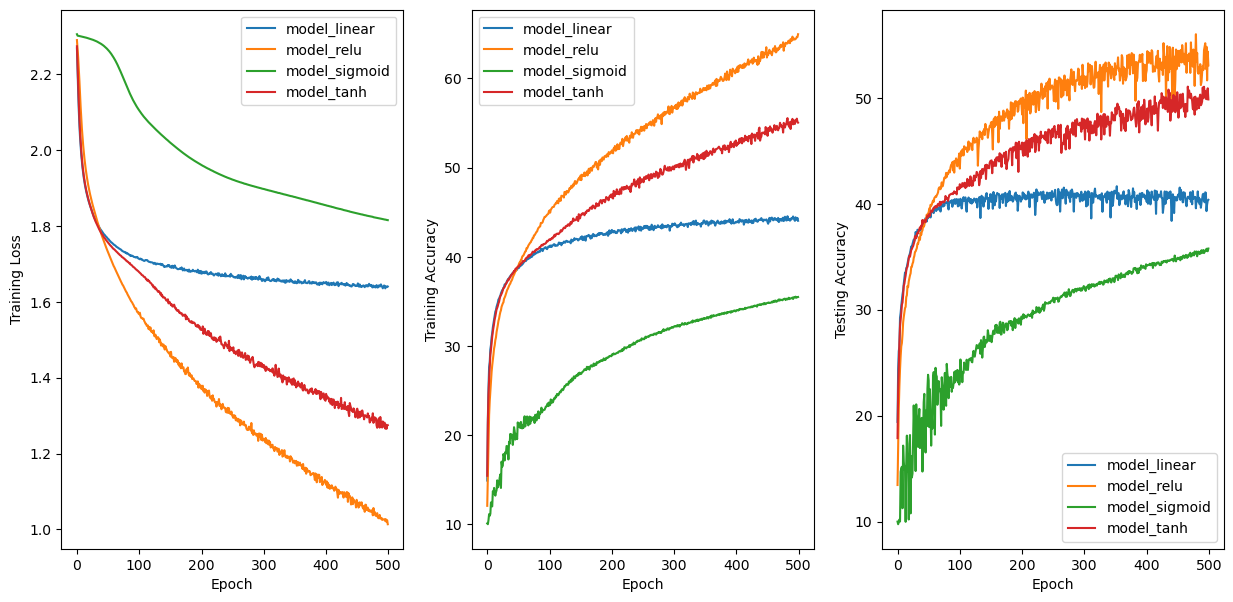

In [17]:
# Hyperparameters
n_epoch = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# place model and criterion on to the device
model_linear = model_linear.to(device)
model_relu = model_relu.to(device)
model_sigmoid = model_sigmoid.to(device)
model_tanh = model_tanh.to(device)
criterion = criterion.to(device)

models = [model_linear, model_relu, model_sigmoid, model_tanh]
optimizers = [optimizer_linear, optimizer_relu, optimizer_sigmoid, optimizer_tanh]

train_loss = []
train_acc = []
test_acc = []
for model, optimizer in zip(models, optimizers):
    for epoch in range(n_epoch):
        train_epoch_loss, train_epoch_acc = train(trainloader, model, criterion, optimizer, device)
        test_epoch_acc = test(testloader, model, device)

        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        test_acc.append(test_epoch_acc)

plot_loss_acc(train_loss, train_acc, test_acc, n_epoch, model_num=4)
